# Predicting No-Shows for a Hair Salon Owner

In [ ]:
import pandas as pd
import numpy as np

pd.set_option('max_columns', 200)
np.random.seed(42)
%config InlineBackend.figure_format = 'retina'

data = (pd
        .read_csv('../input/hair-salon-no-show-data-set/hair_salon_no_show_wrangled_df.csv')
        .fillna({'book_tod':'Undecided','last_category':'NotApplicable','last_staff':'NotApplicable','last_dow':'NotApplicable', 'last_tod':'NotApplicable'})
        .drop(columns=['Unnamed: 0']))

data.head()

# Data Dictionary

See definitions at: https://www.kaggle.com/frederickferguson/hair-salon-no-show-data-set#hair_salon_no_show_wrangled_df.csv

|Column | Meaning |
|-------|---------|
|book_tod |The booking time of day.|
|book_dow|The booking day-of-week.|
|book_category|The booked service category (COLOR or STYLE)|
|book_staff|The staff member to provide the service.|
|last_category|The client's last booked service category before the current booking or today whichever is greater.|
|last_staff|The staff member who provided the client's last service before the current booking or today whichever is greater.|
|last_day_services|The number of services provided to the client on their last visit before the current booking or today whichever is greater.|
|last_receipt_tot|The amount paid by the client on their last visit before the current booking or today whichever is greater.|
|last_dow|The day-of-week of the client's last booking before before the current booking or today whichever is greater.|
|last_tod|The time-of-day of the client's last booking before the current booking or today whichever is greater.|
|last_noshow|Did the client no-show on their last booking before the current booking or today whichever is greater? (0 - no, 1 - yes)|
|last_prod_flag|Did the client buy a retail product on their last booking before the current booking or today whichever is greater? (0 - no, 1 - yes)|
|last_cumrev|The client's cumulative service revenue as of their last booking before the current booking or today whichever is greater.|
|last_cumbook|The client's cumulative number of bookings as of their last booking before the current booking or today whichever is greater.|
|last_cumstyle|The client's cumulative number of STYLE bookings as of their last booking before the current booking or today whichever is greater.|
|last_cumcolor|The client's cumulative number of COLOR bookings as of their last booking before the current booking or today whichever is greater.|
|last_cumprod|The client's cumulative number of bookings with retail product purchases as of their last booking before the current booking or today whichever is greater.|
|last_cumcancel|The client's cumulative number of appointment cancellations as of their last booking before the current booking or today whichever is greater.|
|last_cumnoshow|The client's cumulative number of no-shows as of their last booking before the current booking or today whichever is|

In [ ]:
data.head()

# What is the problem we are trying to solve?

In [ ]:
import plotly.express as px

px.pie(data, names='noshow', title='How many appointments are No-Shows?')

In [ ]:
print(f'This dataset has {data.shape[0]} rows and {data.shape[1]-1} features')

# Can we help the salon owner reduce their costs without compromising service?

How can we measure this?

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def score_group(y_true, y_pred):
    '''Closer to 0 is better'''
    bookings = len(y_true)
    actual_no_shows = sum(y_true)
    expected_noshows = sum(y_pred)
    actual_arrivals = bookings - actual_no_shows
    predicted_arrivals = bookings - expected_noshows

    return float(predicted_arrivals - actual_arrivals)

def score_predictions(y_true, y_pred, store_size=10, n_samples=1000):
    scores = []
    y_true = pd.Series(y_true)
    y_pred = pd.Series(y_pred)
    
    for i in range(n_samples):
        sample_ids = np.random.randint(low=0, high=len(y_true), size=store_size)
        y_true_sample = np.take(y_true, sample_ids)
        y_pred_sample = np.take(y_pred, sample_ids)
        scores.append(score_group(y_true_sample, y_pred_sample))
        
    ax = sns.boxplot(scores)
    ax.set_title(f'Average: {np.mean(scores):.2f}')
    ax.set_xlabel("Number of extra employees")
    ax.set_xlim(-store_size,store_size)
    plt.show()
    return pd.Series(scores).describe().to_frame().T.round(3)

In [ ]:
# Example
y_true = [0,0,0,1,0,0,1,0,0]
y_pred = [0,0,0,0,0,0,0,0,1]

score_predictions(y_true, y_pred)

In [ ]:
data['noshow']

In [ ]:
# Example
y_true = [0 ,  1,  0, 1, 1,  0,  1,  0,  1]
y_pred = [.4, .4, .2, 0, 0, .1, .7, .3, .9] # Probabilities of not showing up

score_predictions(y_true, y_pred)

# Building a Model (and what is a model anyhow?)

We need to give every booking a probability of being a no-show.

![](https://upload.wikimedia.org/wikipedia/commons/b/b8/Apple_slicing_function.png)

A **Model** is any set of assumptions and rules that let us do this.

The input is the set of features we know about each booking. e.g.

    {'book_tod': 'afternoon',
     'book_dow': 'Wednesday',
     'book_category': 'STYLE',
     'book_staff': 'JJ',
     'last_category': 'NotApplicable',
     'last_staff': 'NotApplicable',
     'last_day_services': 0,
     'last_receipt_tot': 0.0,
     'last_dow': 'NotApplicable',
     'last_tod': 'NotApplicable',
     'last_noshow': 0,
     'last_prod_flag': 0,
     'last_cumrev': 0,
     'last_cumbook': 0,
     'last_cumstyle': 0,
     'last_cumcolor': 0,
     'last_cumprod': 0,
     'last_cumcancel': 0,
     'last_cumnoshow': 0,
     'recency': 0}
     
and the output is a probability that they will be a No-Show

In [ ]:
features = data.drop(columns=['noshow'])
y_true = data['noshow']

# Baseline Model 1: What if we predicted that everyone is going to show up?

In [ ]:
y_pred = np.zeros_like(y_true)

score_predictions(y_true, y_pred)

# Baseline 2: Rule Based Model

Can we come up with a set of rules that generate better predictions than the rule based model?

In [ ]:
data.head()

In [ ]:
# https://plot.ly/python/parallel-categories-diagram/
px.parallel_categories(data, color='noshow')

In [ ]:
# Sample Solution
def predict_on_row(row):
    if row['book_tod'] is 'Undecided':
        return 0.5
    elif row['book_tod'] in ['morning','evening']:
        return 0.05
    else:
        return 0.10
    
y_pred = features.apply(predict_on_row, axis=1)

In [ ]:
score_predictions(y_true, y_pred)

In [ ]:
# Try writing your own rules

def predict_on_row(row):
    if (row['last_noshow'] is 1) and (row['last_staff'] is 'NotApplicable'):
        return 0.90
    elif (row['last_noshow'] is 0) and (row['last_staff'] is not 'NotApplicable'):
        return 0.05
    else:
        return 0.20
    
y_pred = features.apply(predict_on_row, axis=1)
score_predictions(y_true, y_pred)

# Building a Machine Learning Model

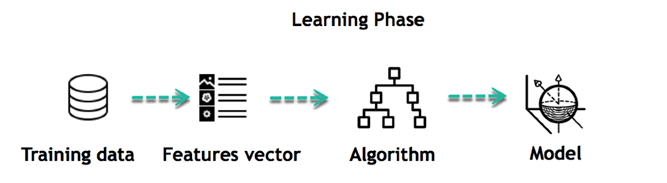

There are many machine learning algorihms, each with dozens of variations and infinitely many configurations...

Examples:

- **Neighbor Algorithms**: Find similar data-points and use them to make predictions

<img src="https://www.edureka.co/blog/wp-content/uploads/2018/07/KNN-Algorithm-k3-edureka-437x300.png" width="200" height="200" />

- **Suport vector machines**: Find a boundary between the samples from one type and another

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/72/SVM_margin.png/300px-SVM_margin.png" width="200" height="200" />

- **Tree Algorithms**: Find a list questions that indicate what the prediction should be
<img src="https://www.researchgate.net/profile/Haiqiang_Niu/publication/313097644/figure/download/fig6/AS:669651600158730@1536668791749/Color-online-Decision-tree-classifier-and-corresponding-rectangular-regions-shown-for.ppm" width="200" height="200" />

In [ ]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth=4, random_state=2)

model

# Preparing the data

Scikit-Learn's implementation can't handle non-numeric features. We can use one-hot encoding (dummy columns) to turn all our data into numbers.

In [ ]:
# Example
df = pd.DataFrame({
    'Col1':['A','A','B','A'],
    'Col2':['X','Y','Y','Y']
})

df

In [ ]:
pd.get_dummies(df)

In [ ]:
X = pd.get_dummies(features)
X.head()

# Cross-Validation

![Bias-Variance-Trade-Off](https://miro.medium.com/max/771/1*cdvfzvpkJkUudDEryFtCnA.png)

![Cross-Validation-Gif](https://imada.sdu.dk/~marco/Teaching/AY2010-2011/DM825/animation.gif)

In [ ]:
from sklearn.model_selection import cross_val_predict

def get_predictions_from_model(model, X, y):
    y_proba = cross_val_predict(model, X, y_true, cv=5, method='predict_proba')
    y_pred = y_proba[:,1]
    return y_pred
    
y_pred = get_predictions_from_model(model, X, y_true)

In [ ]:
score_predictions(y_true, y_pred)

# What is the model doing?

In [ ]:
from sklearn.tree import plot_tree

def visualize_model(model, X, y):
    model.fit(X, y)
    plt.figure(figsize=(50,10))
    
    plot_tree(model, filled=True, feature_names=X.columns, 
                  class_names=model.classes_.astype(str), 
                  proportion=True, impurity=False, rounded=True)
    
    plt.show()
    
visualize_model(model, X, y_true)

# Optimizing the Model

In [ ]:

help(DecisionTreeClassifier)

In [ ]:
model = DecisionTreeClassifier(max_depth=1, random_state=1)

y_pred = get_predictions_from_model(model, X, y_true)

score_predictions(y_true, y_pred)

# Other Models

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

model_lr = LogisticRegression()
model_rfc = RandomForestClassifier(n_estimators=100)
model_knn = KNeighborsClassifier()

In [ ]:
# Experiment


# Explaining the Predictions Using SHAP

In [ ]:
import shap
shap.initjs()

In [ ]:
model = DecisionTreeClassifier(max_depth=5)
model.fit(X,y_true)

explainer = shap.TreeExplainer(model, data=X)
shap_values =  explainer.shap_values(X=X)[1]

def visualize_row_predictions(ix, shap_values=shap_values, features=X):
    return shap.force_plot(np.mean(shap_values), shap_values[ix,:], feature_names=X.columns, features=features.iloc[ix,:], link='logit')

In [ ]:
visualize_row_predictions(2)

In [ ]:
visualize_row_predictions(190)